In [3]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import sys
sys.path.append('/remote/tychodata/ftairli//work/Projects/MuonSignal/Models')

In [4]:
plt.rcParams['figure.figsize'] = [15, 12]

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using Device:', device)

Main  = torch.load('../Data/NormData/Main_test.pt')
Aux   = torch.load('../Data/NormData/Aux_test.pt')
Truth = torch.load('../Data/NormData/Truth_test.pt')
EventMyId = torch.load('../Data/NormData/EventMyId_test.pt')

Aux = Aux.unsqueeze(2)
Truth = Truth.unsqueeze(2)

Main = Main.transpose(1,2)

# Truth = Truth.sum(dim=1).unsqueeze(1)
print(Main.shape, Aux.shape, Truth.shape)

Using Device: cuda
torch.Size([169157, 120, 3]) torch.Size([169157, 4, 1]) torch.Size([169157, 120, 1])


In [6]:
print(Main.mean(dim=[0,2]))

tensor([0.0256, 0.0823, 0.1157, 0.1315, 0.1366, 0.1369, 0.1347, 0.1308, 0.1259,
        0.1205, 0.1146, 0.1086, 0.1028, 0.0970, 0.0913, 0.0858, 0.0805, 0.0756,
        0.0708, 0.0664, 0.0623, 0.0584, 0.0549, 0.0515, 0.0485, 0.0456, 0.0429,
        0.0404, 0.0381, 0.0360, 0.0340, 0.0321, 0.0304, 0.0287, 0.0272, 0.0258,
        0.0245, 0.0233, 0.0222, 0.0211, 0.0201, 0.0191, 0.0182, 0.0173, 0.0165,
        0.0158, 0.0150, 0.0143, 0.0137, 0.0130, 0.0125, 0.0119, 0.0114, 0.0108,
        0.0104, 0.0099, 0.0095, 0.0091, 0.0087, 0.0083, 0.0080, 0.0077, 0.0074,
        0.0071, 0.0068, 0.0065, 0.0062, 0.0060, 0.0058, 0.0055, 0.0053, 0.0050,
        0.0049, 0.0047, 0.0045, 0.0044, 0.0042, 0.0040, 0.0039, 0.0038, 0.0036,
        0.0034, 0.0033, 0.0032, 0.0031, 0.0030, 0.0029, 0.0028, 0.0027, 0.0026,
        0.0025, 0.0024, 0.0023, 0.0022, 0.0021, 0.0021, 0.0020, 0.0019, 0.0018,
        0.0018, 0.0017, 0.0017, 0.0016, 0.0016, 0.0015, 0.0015, 0.0014, 0.0014,
        0.0013, 0.0013, 0.0013, 0.0012, 

In [4]:
print(Aux.shape)
print(Aux.squeeze().unsqueeze(1).shape)
print(Aux.transpose(1,2).shape)

torch.Size([169157, 4, 1])
torch.Size([169157, 1, 4])
torch.Size([169157, 1, 4])


In [5]:
Name = 'Model_3_1'
model   = torch.load(f'../Models/{Name}.pt')
# from Model_1_0 import Model_1_2
# model = Model_1_2()
Tracker = torch.load(f'../Models/{Name}_Tracker.pt')


WantedEpoch = len(Tracker.ModelStates)
print(WantedEpoch)
model.load_state_dict(Tracker.ModelStates[WantedEpoch-1])
print(model.Name)

# Truth is now fraction of the signal in the tank
Truth = model.UnnormaliseY(Truth).sum(dim=1)/model.UnnormaliseY(Main).mean(dim=2).sum(dim=1).unsqueeze(1)



10
Model_3_1


In [6]:
print(Truth.shape)

torch.Size([169157, 1])


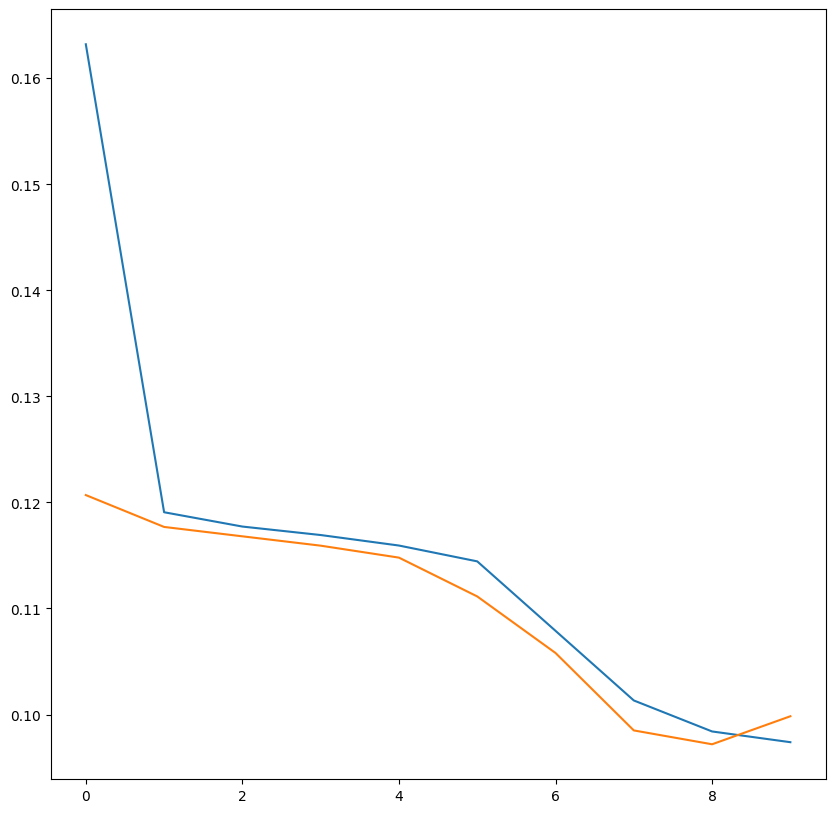

In [7]:
plt.figure(figsize=(10,10))
plt.plot(Tracker.EpochLoss)
plt.plot(Tracker.EpochValLoss)

In [10]:

model = model.to(device)
model.eval()

from Model_1_0 import MyDataset
from torch.utils.data import DataLoader

BatchSize      = 100


test_dataset = MyDataset(Main,Aux,Truth)
dataloader_test = DataLoader(test_dataset,batch_size=BatchSize)

pred  = np.zeros(shape = (Main.shape[0],1))
truth = np.zeros(shape = (Main.shape[0],1))

filled = 0
BatchN = 0
print('Beginging to compute')
with torch.no_grad():
    for batch_Main,batch_Aux,batch_Truth in dataloader_test:

        print(f'\rBatch {BatchN} of {len(dataloader_test)}',end='')

        batch_Main = batch_Main.to(device)
        batch_Aux = batch_Aux.to(device)
        Current_BatchSize = batch_Main.shape[0]
        
        Results = model(batch_Main,batch_Aux)
        Truths  = batch_Truth
        
        pred[filled: filled+Current_BatchSize] = Results.cpu().numpy()
        truth[filled: filled+Current_BatchSize] = Truths.cpu().numpy()
        
        filled += Current_BatchSize
        BatchN += 1

# del model

Beginging to compute
Batch 1691 of 1692

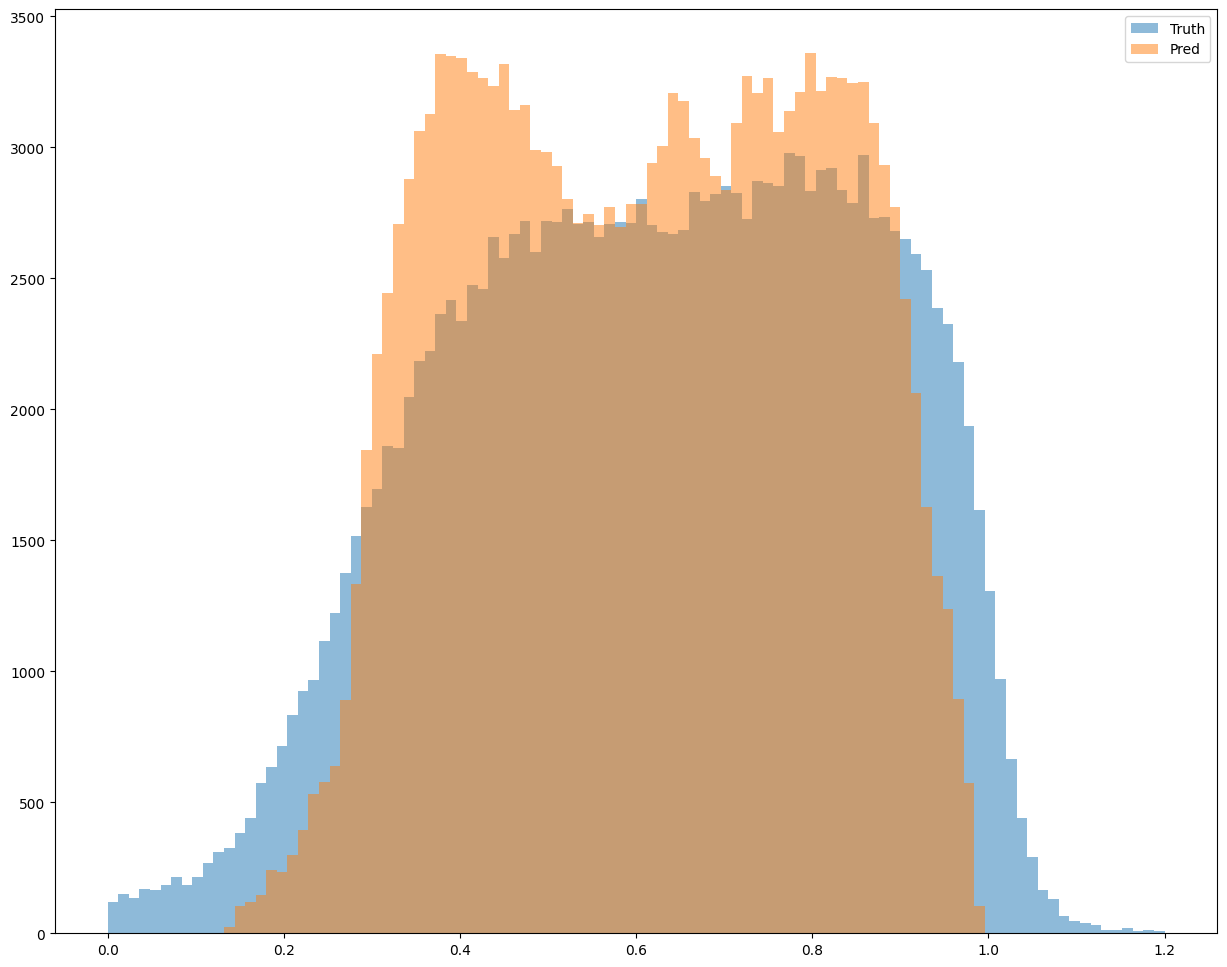

In [24]:
plt.hist(truth,bins = 100,label='Truth',range = [0,1.2],alpha=0.5)
plt.hist(pred,bins = 100,label='Pred',range = [0,1.2],alpha=0.5)
plt.legend()
plt.show()

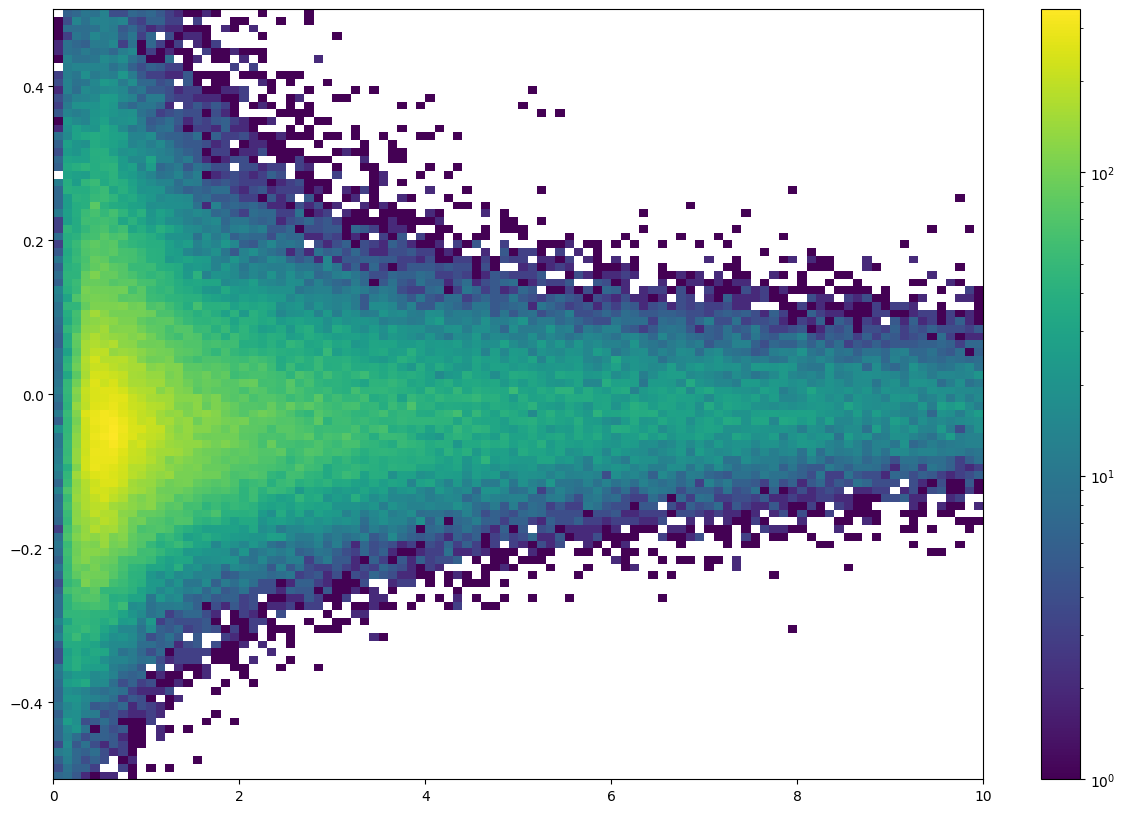

In [48]:
from matplotlib.colors import LogNorm

X = Main.mean(dim=2).sum(dim=1).squeeze().numpy()
Y = (pred - truth).squeeze()
# print(X.shape,type(X))
# print(Y.shape,type(Y))

plt.figure(figsize=(15,10))
Hist = plt.hist2d(X,Y,bins = 100,range = [[0,10],[-0.5,0.5]],norm = LogNorm())
plt.colorbar()
plt.show()
